# 이미지 식별 머신을 위한 데이터를 준비한다.

## 필요한 라이브러리를 불러 온다.

In [2]:
#!pip install torch torchvision

In [3]:
# 데이터 플로팅 라이브러리
import matplotlib.pyplot as plt 
# 숫자 처리 라이브러리
import numpy as np
# 딥러닝을 위한 파이토치 라이브러리
import torch
from torch import nn, optim
# 토치비전 라이브러리
import torchvision
from torchvision import datasets, transforms, models
# 이미지 처리 라이브러리 (PIL, pillow)
from PIL import Image
# 주피터 노트북에서 plot이 보이도록 설정
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## 데이터 디렉토리, 분할 비율, 변환 방법을 설정한다.

In [4]:
# 이미지 데이터가 있는 디렉토리와 데이터 세트 분할 비율(valid_size)을 정한다.
data_dir = './data'
vaild_size = 0.2

# 이미지 데이터를 ResNet50에서 다룰 수 있도록 변환시키는 방법을 정한다. (t_transforms)
t_transforms = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.Resize(224),
                transforms.ToTensor()
])
#convert image size to 224x224 for ResNet50 after crop


### (확인) 변환 방법을 출력하여 확인해 본다.

In [5]:
# 설정한 이미지 데이터 변환 방법을 출력하여 확인한다.
print(t_transforms)


Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


## 데이터를 로딩 함수를 작성한다.

### (연습) trainloader와 testloader를 만들어 본다.

#### 1. 학습 데이터 세트 및 테스트 데이터 세트의 디렉토리 및 변환 방식을 지정한다.

In [6]:
# datasets.ImageFolder를 사용해서 학습 데이터(train_data)와 테스트 데이터(test_data)를 만든다.
# make train_data and test_data using datasets.ImageFolder
train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
test_data = datasets.ImageFolder(data_dir, transform=t_transforms)
# 학습 데이터의 형식을 확인한다.
print(train_data)

# 학습 데이터와 테스트 데이터의 길이를 확인한다.
print(len(train_data), len(test_data))



Dataset ImageFolder
    Number of datapoints: 155
    Root location: ./data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
155 155


#### 2. 데이터세트를 섞기 위해, 우선 인덱스를 만들어 랜덤하게 섞는다.

In [7]:
# train_data 사이즈만큼의 정수값을 갖는 인덱스 리스트(indices)를 만들고 확인한다.
num_train = len(train_data)
indices = list(range(num_train))
print(indices)
# 인덱스 리스트를 랜덤하게 섞고 확인한다.
np.random.shuffle(indices)
print(indices)



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
[25, 71, 86, 140, 34, 43, 19, 99, 22, 152, 93, 94, 90, 138, 66, 41, 72, 60, 50, 61, 39, 12, 79, 11, 28, 38, 10, 48, 62, 75, 73, 16, 120, 109, 113, 147, 108, 107, 36, 122, 26, 104, 84, 82, 132, 85, 0, 13, 126, 77, 151, 5, 51, 15, 74, 136, 153, 98, 68, 144, 2, 42, 146, 111, 59, 18, 154, 81, 69, 63, 116, 6, 142, 83, 128, 29, 56, 45, 17

#### 3. 분할 비율(valid_size)에 따른 지점의 인덱스 값(split)을 계산한다.

In [8]:
# 분할 비율(valid_size)에 해당하는 인덱스를 계산하고 확인해 본다.
split = int(np.floor(num_train * vaild_size))
print(split)

31


#### 4. split을 기준으로 학습 데이터 인덱스 리스트와 테스트 인덱스 리스트로 나눈다.

In [9]:
# 학습 데이터 인덱스 리스트 및 테스트 인덱스 리스트를 만들고 확인해 본다.
train_idx, test_idx = indices[split:], indices[:split]

print(train_idx)
print(test_idx)

[16, 120, 109, 113, 147, 108, 107, 36, 122, 26, 104, 84, 82, 132, 85, 0, 13, 126, 77, 151, 5, 51, 15, 74, 136, 153, 98, 68, 144, 2, 42, 146, 111, 59, 18, 154, 81, 69, 63, 116, 6, 142, 83, 128, 29, 56, 45, 17, 135, 54, 95, 131, 55, 80, 4, 130, 124, 21, 57, 87, 58, 20, 53, 105, 121, 134, 143, 91, 52, 96, 123, 24, 65, 145, 127, 88, 46, 100, 40, 8, 119, 102, 32, 78, 92, 125, 30, 47, 67, 106, 27, 133, 89, 64, 23, 137, 7, 9, 139, 118, 148, 49, 76, 129, 114, 33, 35, 115, 1, 97, 150, 14, 70, 149, 112, 141, 117, 44, 101, 103, 37, 3, 31, 110]
[25, 71, 86, 140, 34, 43, 19, 99, 22, 152, 93, 94, 90, 138, 66, 41, 72, 60, 50, 61, 39, 12, 79, 11, 28, 38, 10, 48, 62, 75, 73]


#### 5. 데이터 세트들의 샘플러 및 로더를 만들고 확인한다.

In [10]:
# 데이터 샘플링 방식(SubsetRandomSampler)을 지정한다
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
# 데이터 로딩을 위한 loader를 만든다. (sampler, 배치 사이즈 등 지정)
trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)
# 학습 loader와 테스트 loader의 class들을 출력하여 확인한다.
print(trainloader.dataset.classes)
print(testloader.dataset.classes)


['Basalt', 'Highland']
['Basalt', 'Highland']


### 코드들을 묶어서 load_split_train_test() 함수를 만든다.

In [11]:
# 위의 코드들을 묶어서 load_split_train_test() 함수를 만든다. (입력 : 데이터 디렉토리, 분할 비율) (출력 : 학습 데이터 로더, 테스트 데이터 로더)
def load_split_train_test(data_dir, vaild_size):
    t_transforms = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.Resize(224),
                transforms.ToTensor()])

    train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    indices = list(range(num_train))

    np.random.shuffle(indices)
    split = int(np.floor(num_train * vaild_size))
    train_idx, test_idx = indices[:split], indices[split:]

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

    return trainloader, testloader


### load_split_train_test() 함수를 이용하여 trainloader, testloader를 생성한다.

In [12]:
# load_split_train_test() 함수를 이용하여 trainloader와 testloader를 만들고 확인한다.
trainloader, testloader = load_split_train_test(data_dir, 0.2)

print(trainloader.dataset.classes)
print(testloader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


## 이미지 데이터 샘플들을 살펴본다.

### 임의의 데이터를 로딩한 후 이미지와 레이블을 반환하는 get_random_images() 함수를 만든다.

In [13]:
def get_random_images(num):
    
    data = datasets.ImageFolder(data_dir, transform= t_transforms)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]

    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size = num)

    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    return images, labels

### 임의 선택한 이미지를 표시해 본다.

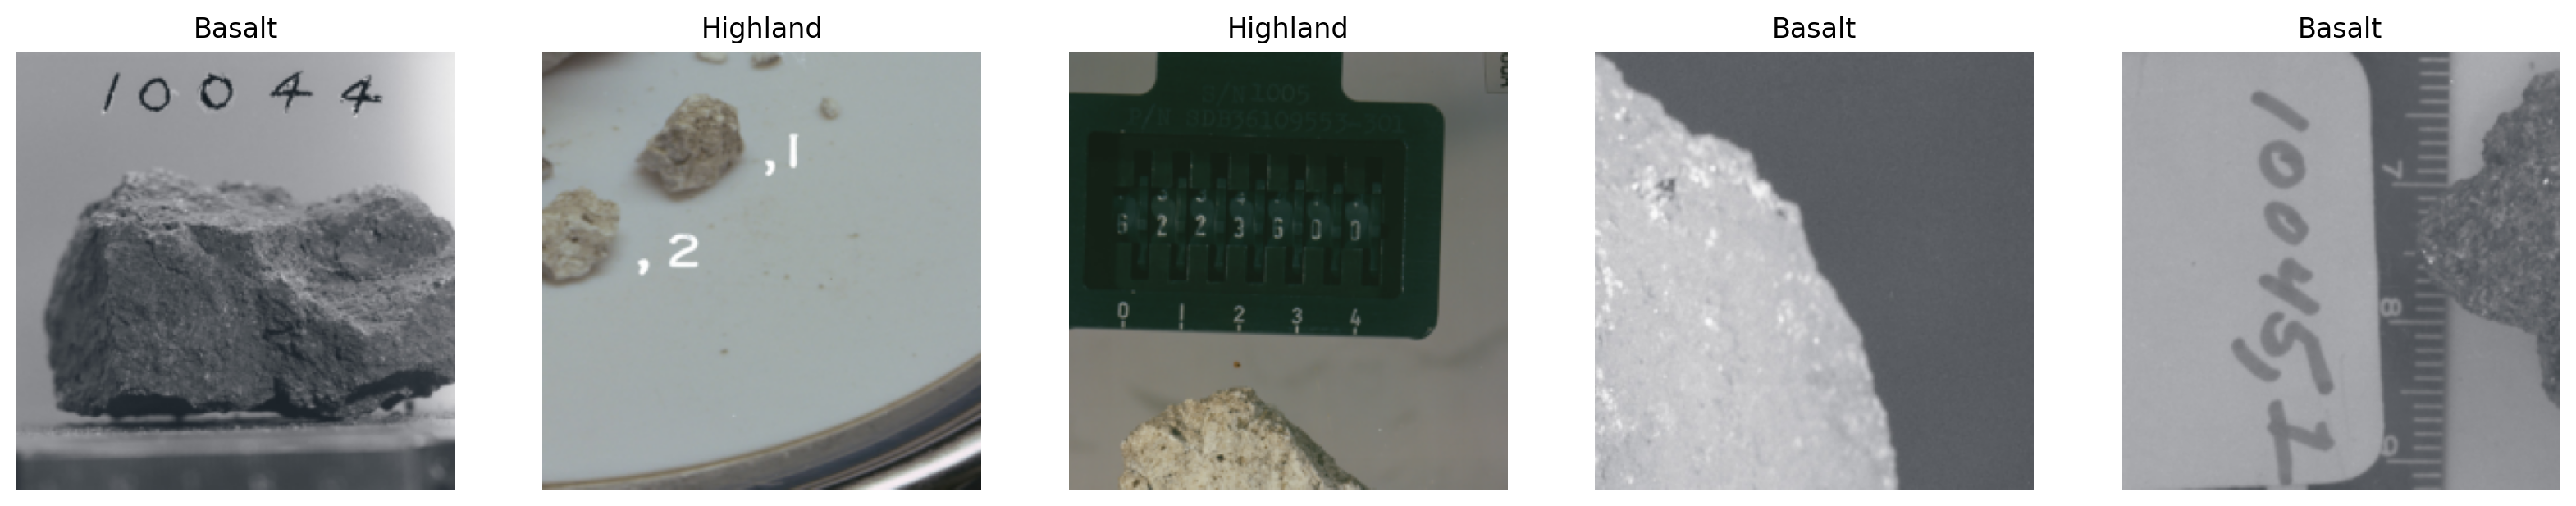

In [14]:
# 5개의 이미지와 레이블을 랜덤하게 가져온다.
images, labels = get_random_images(5)
# 픽셀 배열을 PIL 형식의 이미지로 변환하고 이미지 크기를 지정한다.
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(20,20))


# 학습 데이터의 class 리스트를 얻는다.
classes = trainloader.dataset.classes

# 이미지를 표시하기 위한 설정을 한다.
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    index = labels[ii].item()
    sub.set_title(classes[index])
    plt.axis('off')
    plt.imshow(image)
# 주피터 노트북에 이미지를 표시한다.
plt.show()


# ResNet50 모델을 가져와 FCL(Fully Connected Layer)을 수정한다.

## Compute device를 정한다(CPU or GPU)

In [15]:
# compute device를 정하고 확인한다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 사전학습된 ResNet50 모델을 지정한다.

In [16]:
# resnet50 모델을 pretrained=True로 설정한다.
model = models.resnet50(pretrained=True)

/home/codespace/.python/current/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/codespace/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
61.5%

100.0%


### (확인) 수정 전의 ResNet50 모델을 확인해 본다. 

In [17]:
model = models.resnet50(pretrained=True)

## FCL을 수정한다.(뉴런 구축, 신경망 연결, FCL의 layer 설정 등)

In [18]:
# 모든 신경망 구축 : 전이학습을 위해 모델의 가중치를 freeze 한다.
for param in model.parameters():
    param.requires_grad = False
# 뉴런들을 연결하여 신경망을 생성한다.
model.fc = nn.Sequential(nn.Linear(2048,512), nn.ReLU(),nn.Dropout(0.2),nn.Linear(512,2),nn.LogSoftmax(dim=1))


# q: explain the above code
# a: 2048개의 입력을 받아 512개의 출력을 내고, ReLU 함수를 거쳐 0.2의 확률로 Dropout을 적용한다.
# 512개의 입력을 받아 2개의 출력을 내고, LogSoftmax 함수를 거쳐 1차원으로 변환한다.
# 1차원으로 변환된 출력을 갖는 신경망을 생성한다.

# 손실함수를 Cross entropy loss 함수로 지정한다.
criterion = nn.NLLLoss()
# why
# optimizer를 Adam으로 지정한다.
# what is Adam
optimizer = optim.Adam(model.fc.parameters(), lr=0.03)

# 신경망을 compute device로 보낸다.
model.to(device)
# 종료 여부를 출력한다.
print('done!')



done!


### (확인) FCL을 확인해 본다.

In [19]:
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
  (4): LogSoftmax(dim=1)
)


# 모델의 FCL을 학습시키고 테스트 한다.

## 모델 학습/검증을 위한 변수를 설정한다.

In [35]:
# 에폭 및 출력 간격을 설정한다.
epochs = 20
print_every = 5
# 손실 변수들을 초기화 한다.
running_loss = 0
train_losses, test_losses = [], []
# 현재의 학습 단계를 표현하는 steps 변수를 0으로 초기화 한다.
steps = 0




## 설정한 에폭만큼 모델을 학습시키며 검증/평가 한다.

In [38]:
# 설정한 회수만큼 학습 후 테스트 및 평가해 본다.
for epoch in range(epochs):
    epoch += 1

    for inputs, labels in trainloader:

        steps +=1
        print('Training step' , steps)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            print("Epoch {}/{}:".format(epoch, epochs), "Train loss: {:.3f}..".format(running_loss/print_every),"Test loss{:.3f}..".format(test_loss/len(testloader)), "Test accuracy: {:.3f}\n".format(accuracy/len(testloader)))

            running_loss = 0
            model.train()
            break


Training step 35
Epoch 1/20: Train loss: 0.196.. Test loss0.151.. Test accuracy: 0.958

Training step 36
Training step 37
Training step 38
Training step 39
Training step 40
Epoch 4/20: Train loss: 0.091.. Test loss0.179.. Test accuracy: 0.935

Training step 41
Training step 42
Training step 43
Training step 44
Training step 45
Epoch 7/20: Train loss: 0.131.. Test loss0.180.. Test accuracy: 0.919

Training step 46
Training step 47
Training step 48
Training step 49
Training step 50
Epoch 10/20: Train loss: 0.218.. Test loss0.323.. Test accuracy: 0.846

Training step 51
Training step 52
Training step 53
Training step 54
Training step 55
Epoch 13/20: Train loss: 0.217.. Test loss0.124.. Test accuracy: 0.953

Training step 56
Training step 57
Training step 58
Training step 59
Training step 60
Epoch 16/20: Train loss: 0.098.. Test loss0.138.. Test accuracy: 0.951

Training step 61
Training step 62
Training step 63
Training step 64
Training step 65
Epoch 19/20: Train loss: 0.081.. Test loss0.

### (확인) 학습 손실값과 테스트 손실값을 그래프로 확인한다.

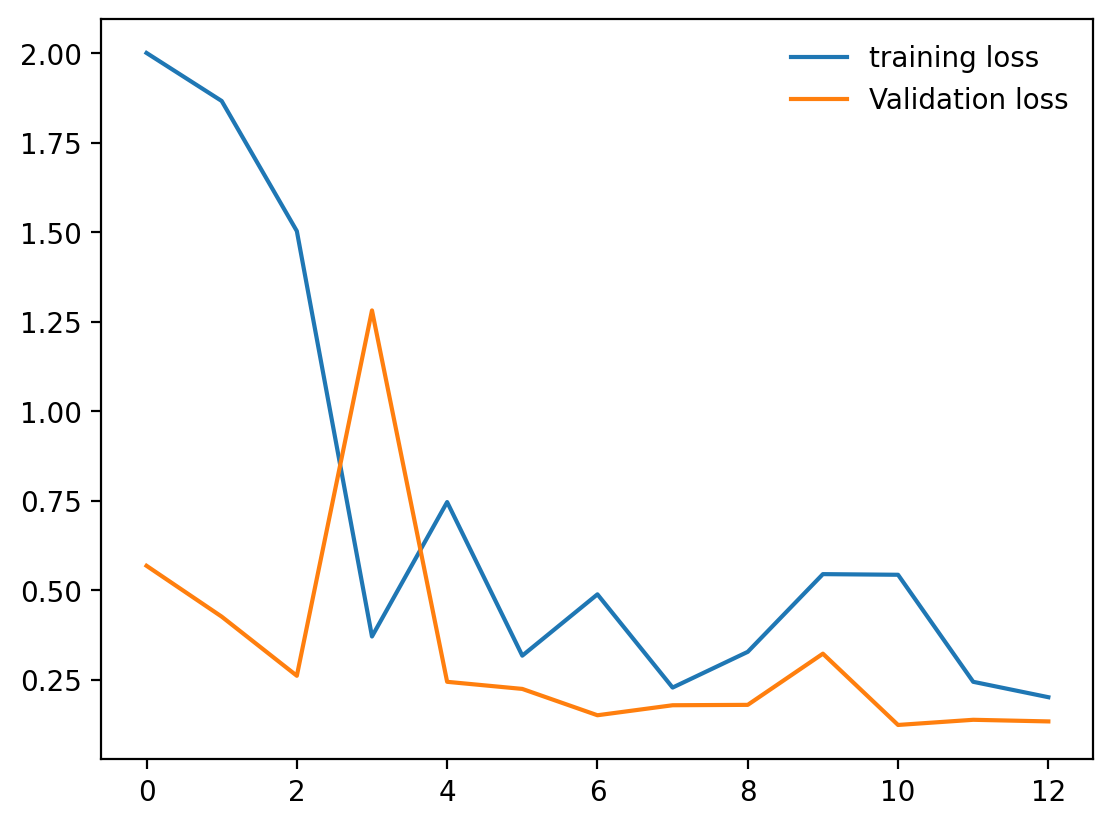

In [39]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

# in this graph, what is x-axis? y-axis?
# x-axis: epoch
# y-axis: loss

# 학습/테스트 완료된 모델을 저장한다.

In [33]:
# 추후 로드하여 사용할 수 있도록 학습/테스트 완료된 모델을 저장한다.
torch.save(model, 'moonrockmodel.pth')

# 완성된 모델을 사용하여 예측한다.

## 저장한 모델을 불러온다.

In [34]:
# 저장한 모델을 불러온다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('moonrockmodel.pth')

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torchvision.models.resnet.ResNet was not an allowed global by default. Please use `torch.serialization.add_safe_globals([ResNet])` or the `torch.serialization.safe_globals([ResNet])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

### (확인) 불러온 모델을 확인해 본다.

In [27]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 이미지 예측을 위해 predict_image() 함수를 만든다.

In [29]:
def predict_image(image):
    image_tensor = t_transforms(image).float()
    input = image_tensor.unsqueeze_(0)
    input = input.to(device)
    output = model(input)
    index = output.data.numpy().argmax()

    return index

## 5개의 이미지를 임의로 가져와 예측해 본다.

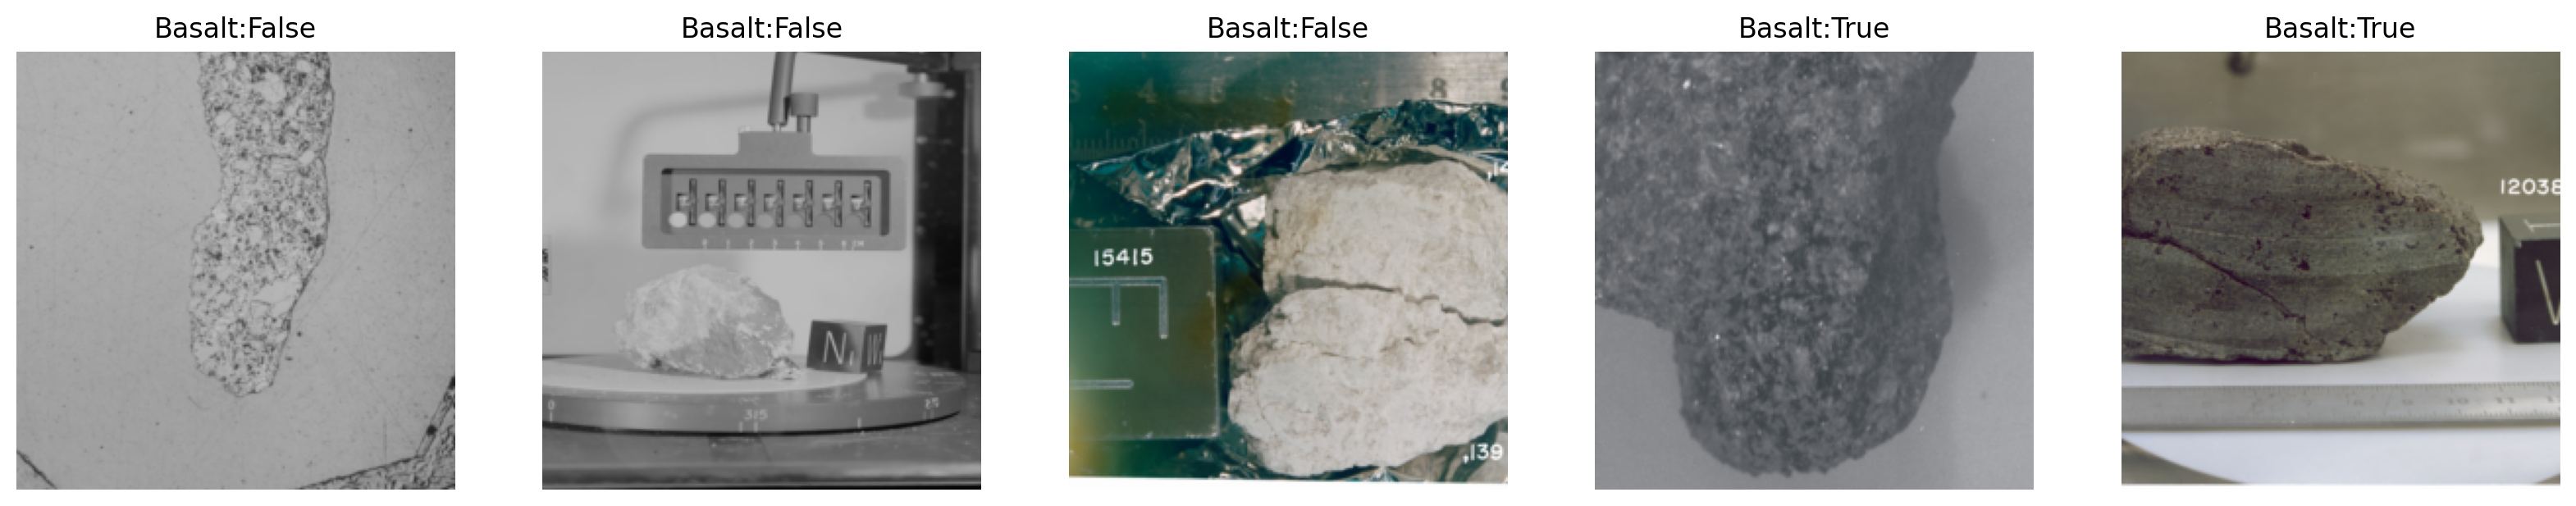

In [31]:
model.eval()

to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig = plt.figure(figsize=(20,20))
classes = trainloader.dataset.classes

for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = labels[ii].item() == index
    sub.set_title(classes[index]+ ":" +str(res))
    plt.axis('off')
    plt.imshow(image)

plt.show()



